# Определение языка и VK API

В данном задании вам нужно будет:

* используя API Вконтакте, скачать комментарии к первым ста постам из пяти сообществ
* натренировать модель распознавания языков на статьях из Википедии.
* распознать язык всех комментариев, где в тексте есть 10 и более символов, и построить статистику

## VK API

Для подключения к ВКонтакте мы будем использовать VK API. Здесь есть документация к этой библиотеке https://vk-api.readthedocs.io/en/latest/

In [0]:
!pip install vk_api
!pip install wikipedia
!pip install nltk
!pip install sklearn
!pip install matplotlib==3.0.3
!pip install seaborn

from collections import Counter 
from nltk.tokenize import word_tokenize, ToktokTokenizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn import feature_extraction
import nltk
import wikipedia
import vk_api
import re
from sklearn import pipeline
from sklearn import naive_bayes
import numpy as np

%pylab inline
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')

In [0]:
user = '+79241052393'
password = 'rhcp9991' 

vk_session = vk_api.VkApi(login=user, password=password)
vk_session.auth()

vk = vk_session.get_api() 

Получить записи со страницы можно с помощью метода `wall.get`. Он принимает параметр `domain` — короткое имя пользователя или сообщества — и `count` — количество записей, которое вы хотите получить (максимум — 100). По Список методов для работы со стенами: https://vk.com/dev/wall

Например, вот так можно получить последние две записи с вот этой страницы https://vk.com/futureisnow. Выдача представляет собой словарь, в котором в поле `items` записан список словарей, содержащий информацию о каждой из записи. 

In [0]:
vk.wall.get(domain="futureisnow", count=2)

С помощью метода `groups.getById` можно получить информацию о сообществе, в том числе его id.

In [0]:
vk.groups.getById(group_ids="futureisnow")

Скачайте информацию о последних ста записях в следующих пабликах: https://vk.com/futureisnow, https://vk.com/eternalclassic, https://vk.com/ukrlit_memes, https://vk.com/ukrainer_net, https://vk.com/amanzohel, https://vk.com/barg_kurumk_culture

In [0]:
# список domain'ов, чтобы вам не копировать их самими :)
publics = ["futureisnow",
           "eternalclassic",
           "ukrlit_memes", 
           "ukrainer_net",
           "amanzohel",
           "barg_kurumk_culture"]

In [6]:
items = {} # ключи — это паблики

# ваш код
for domain in publics:
      posts_inf = vk.wall.get(domain=domain, count=100)
      posts = posts_inf['items']
      items[domain] = list(posts)

for k,v in items.items():
  print(k,len(v))

futureisnow 100
eternalclassic 100
ukrlit_memes 100
ukrainer_net 100
amanzohel 100
barg_kurumk_culture 100


Найдите в документации (https://vk.com/dev/wall) метод для получения комментариев и получите первые сто комментариев каждого поста из выборки для каждого паблика.

In [0]:
corpora = {}

for public in publics:
  comments = []
  posts_inf = vk.wall.get(domain=public, count=100)
  posts = posts_inf['items']
  for post in posts:
    post_id = post['id']
    owner_id = post['from_id']
    comments_inf = vk.wall.getComments(domain=public,post_id=post_id,owner_id = owner_id, count=100)
    for comment in comments_inf['items']:
      try:
        com_text = comment['text'] 
        comments.append(com_text)
      except KeyError:                 
         continue
  corpora[public] = comments

for k,v in corpora.items():
  print(k,len(v),v)

#чистить текст комментариев буду потом

**Задание со звездочкой:** вы могли заметить, что если обращаться к каждому посту отдельно, то все занимает довольно продолжительное время (около пяти минут). Найдите в документации vk_api способ сделать это быстрее.

In [0]:
corpora = {}

# ваш улучшенный код

## Тренировка моделей

В наших комментариях встречались русский, украинский, английский и бурятский.

In [0]:
langs = {'ru', 'uk', 'en', 'bxr'}

Скачайте документы, на которых вы будете обучать свои модели. Для наших целей хорошо иметь для каждого языка корпус размером около 50 статей.

In [45]:
wiki_texts = {}

def get_texts_for_lang(lang, n):
    wiki_content = []
    wikipedia.set_lang(lang)
    pages = wikipedia.random(n)
    for page_name in pages:
        try:
            page = wikipedia.page(page_name)
            wiki_content.append("%s\n%s" % (page.title, page.content.replace('=', '')))
        except wikipedia.exceptions.WikipediaException:
            print("Skip %s" % page_name)
    return wiki_content


for lang in langs:
    wiki_texts[lang] = get_texts_for_lang(lang, 50)
    print(lang, len(wiki_texts[lang]))

/usr/local/lib/python3.6/dist-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.6/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Skip Go (Kreva album)
Skip Venus Flytrap (rock band)
Skip Maksim Pichugin
Skip Constitution Square
en 46
bxr 50
Skip Флекс
Skip DJ (значения)
Skip Большие Ясырки
ru 47
Skip Пшонка
Skip Костевич
Skip Ольшавка
Skip Олні
uk 46


In [0]:
for k,v in wiki_texts.items():
  print(k,len(v),v)

Сделайте определялку на частотах слов.

In [0]:
freq_lists = {}

def collect_freqlist(wiki_pages, max_len=100):
    freqlist = Counter()
    for text in wiki_pages:
        for word in nltk.word_tokenize(text.lower()):
            if word.isalpha():
                freqlist[word] += 1
    return dict(freqlist.most_common(max_len))
# проверка
#collect_freqlist(wiki_texts['ru'])

for lang in langs:
    freq_lists[lang] = collect_freqlist(wiki_texts[lang])

def simple_lang_detect(freq_lists, text):
    counts = Counter()
    for lang, freq_list in freq_lists.items():
        freq_list = Counter(freq_list)
        for word in nltk.word_tokenize(text):
            counts[lang] += int(freq_list[word] > 0)
    return counts.most_common()

Сделайте определялку на символьных энграммах.

In [88]:
vectorizer = feature_extraction.text.TfidfVectorizer(ngram_range=(1, 5), analyzer='char')
vectorizer.fit(wiki_texts['ru'])
#print(vectorizer.transform(wiki_texts['ru'])[0])  # первый документ в векторном представлении
clf = pipeline.Pipeline([
    ('vctr', feature_extraction.text.TfidfVectorizer(ngram_range=(1, 2), analyzer='char')),
    ('clf', naive_bayes.MultinomialNB())
])
all_texts = []
lang_indices = []
for lang in wiki_texts:
    all_texts.extend(wiki_texts[lang])
    lang_indices.extend([lang]*len(wiki_texts[lang]))
# Обучаем классификатор
clf.fit(np.array(all_texts), np.array(lang_indices))

Pipeline(memory=None,
         steps=[('vctr',
                 TfidfVectorizer(analyzer='char', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [91]:
# Предсказываем результаты для тех же текстов
#clf.predict(all_texts)

# Скачиваем новые тексты из вики и предсказываем еще раз
clf.predict(get_texts_for_lang('be',n=10))

array(['uk', 'uk', 'ru', 'uk', 'uk', 'uk', 'uk', 'uk', 'uk', 'uk'],
      dtype='<U3')

In [0]:
# Поделим корпус на train и test
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(all_texts,
                                                    lang_indices,
                                                    test_size=0.2,
                                                    random_state=0)
clf.fit(X_train, y_train)
y_predicted = clf.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_predicted)

In [93]:
print(y_predicted)
print(y_test)

['ru' 'bxr' 'uk' 'bxr' 'ru' 'bxr' 'en' 'ru' 'uk' 'en' 'en' 'uk' 'en' 'uk'
 'uk' 'ru' 'en' 'bxr' 'ru' 'ru' 'bxr' 'ru' 'ru' 'uk' 'uk' 'uk' 'bxr' 'bxr'
 'ru' 'en' 'en' 'bxr' 'bxr' 'en' 'en' 'en' 'uk' 'ru']
['ru', 'bxr', 'uk', 'bxr', 'ru', 'bxr', 'en', 'ru', 'uk', 'en', 'en', 'uk', 'uk', 'uk', 'uk', 'ru', 'en', 'bxr', 'ru', 'ru', 'bxr', 'ru', 'ru', 'uk', 'uk', 'uk', 'bxr', 'bxr', 'ru', 'en', 'en', 'bxr', 'bxr', 'en', 'en', 'en', 'uk', 'ru']


              precision    recall  f1-score   support

         bxr       1.00      1.00      1.00         9
          en       0.90      1.00      0.95         9
          ru       1.00      1.00      1.00        10
          uk       1.00      0.90      0.95        10

    accuracy                           0.97        38
   macro avg       0.97      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38



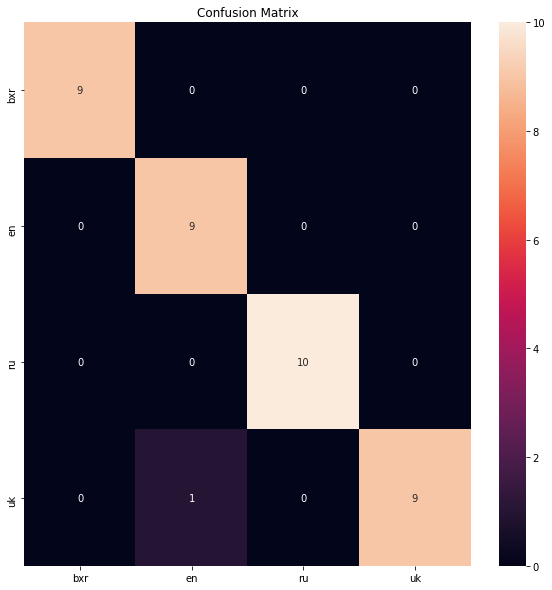

In [94]:
# Нарисуем confusion matrix и оценим качество
def test_classify(y_test, y_predicted, label_names):
    cm = metrics.confusion_matrix(y_test, y_predicted)
    
    plt.figure(figsize=(10, 10))
    plt.ylim(10.5, -0.5)
    sns.heatmap(cm, annot=True,  fmt='', xticklabels=label_names, yticklabels=label_names)
    plt.title('Confusion Matrix')
    
    print(metrics.classification_report(y_test, y_predicted,
                                        target_names=label_names))
test_classify(y_test, y_predicted, clf.classes_)

# Определение языка

Определите язык каждого комментария в каждом паблике с помощью определялки на частотах слов и покажите доли языков среди комментариев для каждого паблика.

In [62]:
lang_detects_freqs = {}

for k,v in corpora.items():
  langgs_comments = []
  for comment in v:
    if len(comment) > 10:
      try:
        lang_of_comment = simple_lang_detect(freq_lists,comment)[0][0]
        langgs_comments.append(lang_of_comment)
      except IndexError:
        continue
  lang_detects_freqs[k] = dict(Counter(langgs_comments))

lang_detects_freqs

{'amanzohel': {'bxr': 11, 'en': 201, 'ru': 24, 'uk': 2},
 'barg_kurumk_culture': {'bxr': 20, 'en': 111, 'ru': 98, 'uk': 1},
 'eternalclassic': {'en': 778},
 'futureisnow': {'bxr': 3, 'en': 455, 'ru': 732, 'uk': 13},
 'ukrainer_net': {'en': 75, 'ru': 48, 'uk': 76},
 'ukrlit_memes': {'en': 107, 'ru': 63, 'uk': 76}}

In [82]:
for name_public,v in lang_detects_freqs.items():
  coms = [freq for freq in v.values()]
  print('Доли языков в паблике %s в процентах: ' % name_public)
  for k,v in v.items():
    perc = round((v*100)/sum(coms))
    print(k, perc)

Доли языков в паблике futureisnow в процентах: 
ru 61.0
en 38.0
uk 1.0
bxr 0.0
Доли языков в паблике eternalclassic в процентах: 
en 100.0
Доли языков в паблике ukrlit_memes в процентах: 
uk 31.0
ru 26.0
en 43.0
Доли языков в паблике ukrainer_net в процентах: 
en 38.0
ru 24.0
uk 38.0
Доли языков в паблике amanzohel в процентах: 
en 84.0
ru 10.0
bxr 5.0
uk 1.0
Доли языков в паблике barg_kurumk_culture в процентах: 
ru 43.0
en 48.0
bxr 9.0
uk 0.0


Сделайте то же самое для определителя на символьных энграммах.

In [120]:
# Проверим на наших комментариях

lang_detects_ngrams = {}

for k,v in corpora.items():
  texts = []
  for comment in v:
    if len(comment) > 10:
      texts.append(comment)
  y_predicted_small = clf.predict(texts)
  lang_detects_ngrams[k] = dict(Counter(y_predicted_small))
  
lang_detects_ngrams

{'amanzohel': {'bxr': 201, 'ru': 37},
 'barg_kurumk_culture': {'bxr': 96, 'en': 1, 'ru': 132, 'uk': 1},
 'eternalclassic': {'bxr': 3, 'en': 777},
 'futureisnow': {'bxr': 36, 'en': 49, 'ru': 1115, 'uk': 3},
 'ukrainer_net': {'bxr': 11, 'en': 4, 'ru': 66, 'uk': 118},
 'ukrlit_memes': {'bxr': 8, 'en': 6, 'ru': 110, 'uk': 122}}

In [121]:
for name_public,v in lang_detects_ngrams.items():
  coms = [freq for freq in v.values()]
  print('Доли языков в паблике %s в процентах: ' % name_public)
  for k,v in v.items():
    perc = round((v*100)/sum(coms))
    print(k, perc)

Доли языков в паблике futureisnow в процентах: 
ru 93.0
bxr 3.0
uk 0.0
en 4.0
Доли языков в паблике eternalclassic в процентах: 
en 100.0
bxr 0.0
Доли языков в паблике ukrlit_memes в процентах: 
uk 50.0
ru 45.0
bxr 3.0
en 2.0
Доли языков в паблике ukrainer_net в процентах: 
uk 59.0
en 2.0
ru 33.0
bxr 6.0
Доли языков в паблике amanzohel в процентах: 
bxr 84.0
ru 16.0
Доли языков в паблике barg_kurumk_culture в процентах: 
ru 57.0
bxr 42.0
en 0.0
uk 0.0


Обсудите работу каждого из классификаторов, обсудите ошибки, объясните разницу в результатах.

**Что хорошо:**
ближе к концу работы было уже понятно, какие языки преобладали в каких пабликах. Радует, что итог в обоих классификаторов приближен к реальности. 

**Что плохо:** очевидно, что нужно лучше чистить комментарии (странно, что частотный классификатор вообще работает). Например, хорошо бы убрать стоп слова. В частотной определялке часто попадались моменты, когда частотность сразу нескольких языков совпадала. 
   


